## Import Models

In [1]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\Mhmd Syd\AppData\Local\Temp\pip-req-build-u6ig8qie'



  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\mhmd syd\appdata\local\temp\pip-req-build-u6ig8qie
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7682 sha256=d8877e619b7def7d3250b433cf0fb825e277e1a667c88429552846917842c043
  Stored in directory: C:\Users\Mhmd Syd\AppData\Local\Temp\pip-ephem-wheel-cache-1fa4t41x\wheels\fd\71\47\e04f208ad659a295ccb69022e14de7d20ccc6fc30a5a935f09
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [2]:
# basic lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# nlp preprocessing using tensorflow lib 
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D,Flatten, Bidirectional
# from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
# text prepration lib
import nltk
import re
from wordcloud import WordCloud
import preprocess_kgptalkie as ps
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec
from string import punctuation

**Read Database**

In [3]:
df = pd.read_csv('data/Job titles and industries.csv')
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


## EDA

In [4]:
# rename columns name to can use dot with data and column name.
df.columns = [i.strip().title().replace(" ","_") for i in [*df.columns]]
df.columns

Index(['Job_Title', 'Industry'], dtype='object')

In [5]:
# check out NAN Values in data.
df.isnull().sum()

Job_Title    0
Industry     0
dtype: int64

In [6]:
# distribution for target values.
df.Industry.value_counts()

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: Industry, dtype: int64

In [7]:
# type of data by columns
df.dtypes

Job_Title    object
Industry     object
dtype: object

In [8]:
# change target columns to categorical data.
df.Industry = df.Industry.astype('category')

In [9]:
# reprint data type by columns after last change.
df.dtypes

Job_Title      object
Industry     category
dtype: object

In [10]:
print("Number of rows before remove duplicates : {}".format(df.shape[0]))

Number of rows before remove duplicates : 8586


In [11]:
# duplicated data size.
df.Job_Title[df.duplicated(keep=False)].count()

5710

In [12]:
# drop duplicate data.
df.drop_duplicates(keep='last',inplace=True)

In [13]:
print(f"Number of rows after remove duplicates : {df.shape[0]}")

Number of rows after remove duplicates : 3968


In [14]:
# distribution of target values (count repeted values) after drop duplication.
df.Industry.value_counts()

IT             1529
Marketing      1203
Education       973
Accountancy     263
Name: Industry, dtype: int64

In [15]:
# unique values for target column.
df.Industry.unique()

['IT', 'Marketing', 'Education', 'Accountancy']
Categories (4, object): ['Accountancy', 'Education', 'IT', 'Marketing']

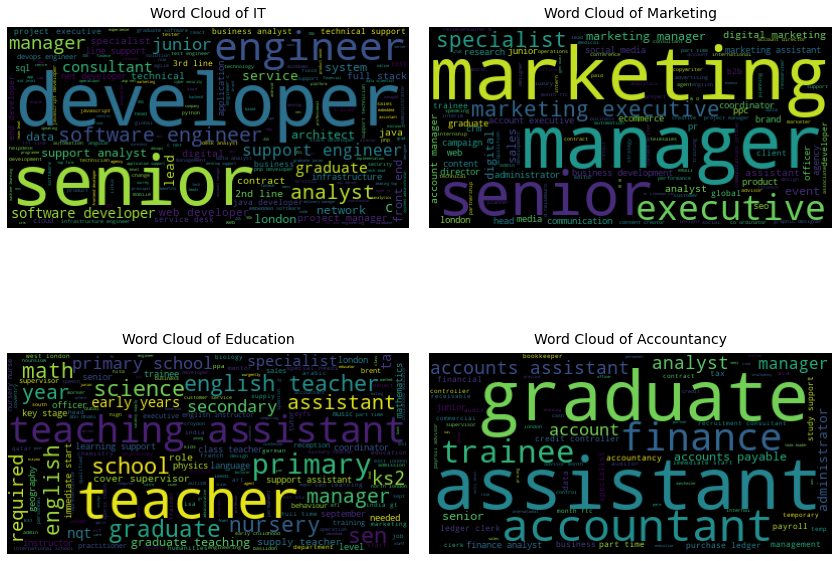

In [16]:
# plot most word repeted with every value in target columns.
fig = plt.figure(figsize=(12,14))

for job_name,index in  zip(df.Industry.unique(), range(1, 5)):
    ax = fig.add_subplot(2, 2, index)
    text = ' '.join(df.Job_Title[df.Industry==job_name].tolist())
    word_Job_Titles = WordCloud().generate(text)
    plt.imshow(word_Job_Titles)
    plt.axis('off')
    plt.title(f"Word Cloud of {job_name}", y=1.02, fontsize=14)
    plt.tight_layout(pad=2)
plt.show()

In [17]:
# clean data and remove speci

df.Job_Title = df.Job_Title.apply(lambda x : ps.remove_special_chars(x))

In [18]:
# --take text and preprocess 
#   1- remove stopwords [a, the, and, thus, ..etc].
#   2- punctations[,%$ .etc].
#   3- len of text less than 3.
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in punctuation and  len(token) >= 3 :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)

In [19]:
# preprocessing text on Job_title columns.
df.Job_Title = df.Job_Title.map(clean_text)
df.head()

,Job_Title,Industry
0,technical support helpdesk supervisor county b...,IT
2,head services,IT
3,end engineer,IT
4,network telephony controller,IT
5,privileged access management expert,IT


In [20]:
# label encode for target columns(Industry).
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df.Industry = encoder.fit_transform(np.array(df.Industry).reshape(-1, 1)).astype('int')

In [21]:
# sample of data after preprocessing.
df.Industry.value_counts()

2    1529
3    1203
1     973
0     263
Name: Industry, dtype: int64

## Data Prepration

In [25]:
# split Job_Title text to list of string.
# X = [line.split() for line in df.Job_Title.tolist()]
X= df.Job_Title

In [26]:
# target values.
y = df.Industry.values

In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
X[0]

<1x1871 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [36]:
def get_weight_matrix(model):
    Dim = 100
    weight_matrix = np.zeros((vocab_size, Dim))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word] 
    return weight_matrix

In [37]:
embeddings_vec = get_weight_matrix(model)

NameError: name 'vocab_size' is not defined

In [38]:
embeddings_vec.shape

(1872, 100)

## Modeling

In [39]:
model = Sequential()
Dim =100
model.add(Embedding(vocab_size, output_dim=Dim))
model.add(Bidirectional(LSTM(units=Dim)))
model.add(Dense(60, activation='relu'))
model.add(Dense(4, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         187200    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 60)                12060     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 244       
Total params: 360,304
Trainable params: 360,304
Non-trainable params: 0
_________________________________________________________________


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
pd.Series(y_train).value_counts()

2    1214
3     965
1     791
0     204
dtype: int64

In [42]:
pd.Series(y_test).value_counts()

2    315
3    238
1    182
0     59
dtype: int64

In [43]:
checkpoint = ModelCheckpoint("weights.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [44]:
num_epochs = 10
history = model.fit(X_train, y_train, 
                    epochs=num_epochs,
                    validation_data=(X_test, y_test),
                    callbacks = [checkpoint],
                    verbose=2)

Epoch 1/10
100/100 - 7s - loss: 0.9115 - accuracy: 0.6276 - val_loss: 0.4557 - val_accuracy: 0.8451

Epoch 00001: val_accuracy improved from -inf to 0.84509, saving model to weights.hdf5
Epoch 2/10
100/100 - 2s - loss: 0.3626 - accuracy: 0.8762 - val_loss: 0.3389 - val_accuracy: 0.8778

Epoch 00002: val_accuracy improved from 0.84509 to 0.87783, saving model to weights.hdf5
Epoch 3/10
100/100 - 2s - loss: 0.2591 - accuracy: 0.9130 - val_loss: 0.3353 - val_accuracy: 0.8829

Epoch 00003: val_accuracy improved from 0.87783 to 0.88287, saving model to weights.hdf5
Epoch 4/10
100/100 - 2s - loss: 0.2213 - accuracy: 0.9250 - val_loss: 0.3655 - val_accuracy: 0.8728

Epoch 00004: val_accuracy did not improve from 0.88287
Epoch 5/10
100/100 - 2s - loss: 0.2004 - accuracy: 0.9288 - val_loss: 0.4481 - val_accuracy: 0.8514

Epoch 00005: val_accuracy did not improve from 0.88287
Epoch 6/10
100/100 - 2s - loss: 0.1775 - accuracy: 0.9379 - val_loss: 0.3693 - val_accuracy: 0.8791

Epoch 00006: val_acc

In [45]:
model.load_weights("weights.hdf5")

In [46]:
y_pred = np.argmax(model.predict(X_train), axis=1)
accuracy_score(y_train, y_pred)

0.9373030875866415

In [47]:
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy_score(y_test, y_pred)

0.8828715365239295

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77        59
           1       0.91      0.89      0.90       182
           2       0.91      0.91      0.91       315
           3       0.85      0.87      0.86       238

    accuracy                           0.88       794
   macro avg       0.86      0.86      0.86       794
weighted avg       0.88      0.88      0.88       794



## Thanks for Read my NoteBook :)